In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV

In [3]:
# Read data file
insurance = pd.read_csv(r"..\..\Dataset\scaledData.csv")

In [4]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,-1.438764,1,-0.453320,0,1,3,0.298584
1,-1.509965,0,0.509621,1,0,2,-0.953689
2,-0.797954,0,0.383307,3,0,2,-0.728675
3,-0.441948,0,-1.305531,0,0,0,0.719843
4,-0.513149,0,-0.292556,0,0,0,-0.776802


In [5]:
# Split the data into features and target dataframe.
features = insurance.drop('charges',axis=1).values
target  = insurance['charges'].values.reshape(-1,1)

featureTrain, featureTest, targetTrain, targetTest = train_test_split(features,target,test_size=0.2, random_state=42)

# Training dataset size
print(featureTrain.shape)
# Testing dataset size
print(featureTest.shape)

(1070, 6)
(268, 6)


## Regression Models

### Linear Regression

In [6]:
# Fit the model using linear regression.
linearRegression = LinearRegression()
linearRegression.fit(featureTrain, targetTrain)

LinearRegression()

In [7]:
# Evaluating the model.

#Cross-Validation
cv = cross_val_score(estimator = linearRegression, X = features, y = target, cv = 10)

#R2 score
lr_train_prediction = linearRegression.predict(featureTrain)
lr_r2_train = r2_score(targetTrain, lr_train_prediction)

lr_test_prediction = linearRegression.predict(featureTest)
lr_r2_test = r2_score(targetTest, lr_test_prediction)

#MSE value
mse = mean_squared_error(targetTest, lr_test_prediction)


print('LINEAR REGRESSION SCORES')
print('Cross Validation : {0:.3f}'.format(cv.mean()))
print('R2 score of training data : {0:.3f}'.format(lr_r2_train))
print('R2 score testing data: {0:.3f}'.format(lr_r2_test))
print('MSE : {0:.3f}'.format(mse))

LINEAR REGRESSION SCORES
Cross Validation : 0.745
R2 score of training data : 0.741
R2 score testing data: 0.783
MSE : 0.230


### Support Vector Machine

In [8]:
# Split features and target.
featuresSVM = insurance.drop('charges',axis=1).values
targetSVM = insurance['charges'].values.reshape(-1,1)

X_Train_SVM, X_Test_SVM, Y_Train_SVM, Y_Test_SVM = train_test_split(featuresSVM,targetSVM,test_size=0.2, random_state=42)

#Fit the model.
X_train_scaled = StandardScaler().fit_transform(X_Train_SVM)
y_train_scaled = StandardScaler().fit_transform(Y_Train_SVM)
X_test_scaled = StandardScaler().fit_transform(X_Test_SVM)
y_test_scaled = StandardScaler().fit_transform(Y_Test_SVM)

supportVector = SVR()

In [9]:
# Hyper parameter tuning.
parameters =  { 'kernel' : ['rbf', 'sigmoid'],
                 'gamma' : [0.001, 0.01, 0.1, 1, 'scale'],
                 'tol' : [0.0001],
                 'C': [0.001, 0.01, 0.1, 1, 10, 100] }
svr_grid = GridSearchCV(estimator=supportVector, param_grid=parameters, cv=10, verbose=4, n_jobs=-1)
svr_grid.fit(X_train_scaled, y_train_scaled.ravel())

Fitting 10 folds for each of 60 candidates, totalling 600 fits


GridSearchCV(cv=10, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 'scale'],
                         'kernel': ['rbf', 'sigmoid'], 'tol': [0.0001]},
             verbose=4)

In [10]:
supportVector = SVR(C=10, gamma=0.1, tol=0.0001)
supportVector.fit(X_train_scaled, y_train_scaled.ravel())
print(svr_grid.best_estimator_)
print(svr_grid.best_score_)

SVR(C=10, gamma=0.1, tol=0.0001)
0.8311282028706671


In [11]:
cv_svr = svr_grid.best_score_

y_pred_svr_train = supportVector.predict(X_train_scaled)
r2_score_svr_train = r2_score(y_train_scaled, y_pred_svr_train)

y_pred_svr_test = supportVector.predict(X_test_scaled)
r2_score_svr_test = r2_score(y_test_scaled, y_pred_svr_test)

mse_svr = mean_squared_error(y_test_scaled, y_pred_svr_test)

print("SUPPORT VECTOR REGRESSION SCORES")
print('CV : {0:.3f}'.format(cv_svr.mean()))
print('R2 score of training data: {0:.3f}'.format(r2_score_svr_train))
print('R2 score of testing data: {0:.3f}'.format(r2_score_svr_test))
print('MSE : {0:.3f}'.format(mse_svr))

SUPPORT VECTOR REGRESSION SCORES
CV : 0.831
R2 score of training data: 0.857
R2 score of testing data: 0.871
MSE : 0.129


### Ridge Regressor

In [12]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

steps = [ ('scalar', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2)),
        ('model', Ridge())]

ridgePipeline = Pipeline(steps)

In [13]:
parameters = { 'model__alpha': [1e-15, 1e-10, 1e-8, 1e-3, 1e-2,1,2,5,10,20,25,35, 43,55,100], 'model__random_state' : [42]}
ridgeRegression = GridSearchCV(ridgePipeline, parameters, cv=10)
ridgeRegression = ridgeRegression.fit(featureTrain, targetTrain.ravel())

c:\Users\sneha\OneDrive\Desktop\Predict-health-insurance-amount\venv\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.25803e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\sneha\OneDrive\Desktop\Predict-health-insurance-amount\venv\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.14414e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\sneha\OneDrive\Desktop\Predict-health-insurance-amount\venv\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.16968e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [14]:
ridgeRegression.best_estimator_, ridgeRegression.best_score_

(Pipeline(steps=[('scalar', StandardScaler()), ('poly', PolynomialFeatures()),
                 ('model', Ridge(alpha=20, random_state=42))]),
 0.8259990140429396)

In [15]:
ridge = Ridge(alpha=20, random_state=42)
ridge.fit(X_train_scaled, y_train_scaled.ravel())
cv_ridge = ridgeRegression.best_score_

y_pred_ridge_train = ridge.predict(X_train_scaled)
r2_score_ridge_train = r2_score(y_train_scaled, y_pred_ridge_train)

y_pred_ridge_test = ridge.predict(X_test_scaled)
r2_score_ridge_test = r2_score(y_test_scaled, y_pred_ridge_test)

mse_ridge = mean_squared_error(y_test_scaled, lr_test_prediction)

print("RIDGE PREGRESSION PREDICTION")
print('CV : {0:.3f}'.format(cv_ridge.mean()))
print('R2 score (train) : {0:.3f}'.format(r2_score_ridge_train))
print('R2 score (test) : {0:.3f}'.format(r2_score_ridge_test))
print('MSE : {0:.3f}'.format(mse_ridge))

RIDGE PREGRESSION PREDICTION
CV : 0.826
R2 score (train) : 0.741
R2 score (test) : 0.784
MSE : 0.216


### Random Forest Regression

In [16]:
# Tune and fit the model.
rf_Regression = RandomForestRegressor()
parameters = { 'n_estimators':[600,1000,1200],
             'max_features': ["auto"],
             'max_depth':[40,50,60],
             'min_samples_split': [5,7,9],
             'min_samples_leaf': [7,10,12],
             'criterion': ['mse']}

rf_grid = GridSearchCV(estimator=rf_Regression, param_grid=parameters, cv=10, n_jobs=-1)
rf_grid = rf_grid.fit(X_train_scaled, y_train_scaled.ravel())

c:\Users\sneha\OneDrive\Desktop\Predict-health-insurance-amount\venv\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
c:\Users\sneha\OneDrive\Desktop\Predict-health-insurance-amount\venv\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


In [17]:
rf_grid.best_score_, rf_grid.best_estimator_

(0.8486202769171708,
 RandomForestRegressor(criterion='mse', max_depth=40, max_features='auto',
                       min_samples_leaf=12, min_samples_split=5,
                       n_estimators=600))

In [18]:
rf_Regression = RandomForestRegressor(max_depth=50, min_samples_leaf=12, min_samples_split=7,n_estimators=1200)
rf_Regression.fit(X_train_scaled, y_train_scaled.ravel())

RandomForestRegressor(max_depth=50, min_samples_leaf=12, min_samples_split=7,
                      n_estimators=1200)

In [19]:
cv_rf = rf_grid.best_score_

y_pred_rf_train = rf_Regression.predict(X_train_scaled)
r2_score_rf_train = r2_score(targetTrain, y_pred_rf_train)

y_pred_rf_test = rf_Regression.predict(X_test_scaled)
r2_score_rf_test = r2_score(y_test_scaled, y_pred_rf_test)

mse_rf = mean_squared_error(y_test_scaled, y_pred_rf_test)

print("RANDOM FOREST REGRESSION SCORES")
print('CV : {0:.3f}'.format(cv_rf.mean()))
print('R2 score (train) : {0:.3f}'.format(r2_score_rf_train))
print('R2 score (test) : {0:.3f}'.format(r2_score_rf_test))
print('MSE : {0:.3f}'.format(mse_rf))

RANDOM FOREST REGRESSION SCORES
CV : 0.849
R2 score (train) : 0.885
R2 score (test) : 0.879
MSE : 0.121


### Model Selection

In [20]:
models = [('Linear Regression', mse, lr_r2_train, lr_r2_test, cv.mean()),
          ('Ridge Regression', mse_ridge, r2_score_ridge_train, r2_score_ridge_test, cv_ridge.mean()),
          ('Support Vector Regression', mse_svr, r2_score_svr_train, r2_score_svr_test, cv_svr.mean()),
          ('Random Forest Regression', mse_rf, r2_score_rf_train, r2_score_rf_test, cv_rf.mean())   
         ]

In [21]:
predict = pd.DataFrame(data = models, columns=['Model', 'MSE', 'R2 (Train)', 'R2 (test)', 'Cross-Validation'])
predict

,Model,MSE,R2 (Train),R2 (test),Cross-Validation
0,Linear Regression,0.230216,0.741410,0.782694,0.744528
1,Ridge Regression,0.216417,0.741150,0.783800,0.825999
2,Support Vector Regression,0.128716,0.857234,0.871284,0.831128
3,Random Forest Regression,0.120926,0.884571,0.879074,0.848620


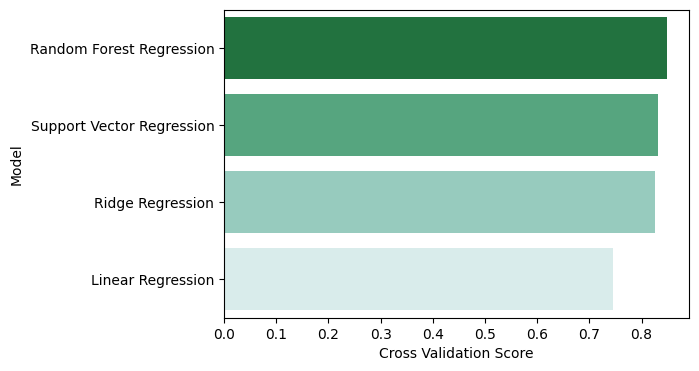

In [22]:
plt.figure(figsize=(6,4))
predict.sort_values(by=['Cross-Validation'], ascending=False, inplace=True)

sns.barplot(x='Cross-Validation', y='Model',data = predict, palette='BuGn_r')
plt.xlabel('Cross Validation Score')
plt.ylabel('Model')
plt.show()

## Random Forest Regression

In [23]:
# saving the unscaled data as a dataframe.
insuranceCopy = pd.read_csv("..\..\Dataset\processedData.csv")

In [24]:
X = insuranceCopy.drop('charges',axis=1).values
y = insuranceCopy['charges'].values.reshape(-1,1)
X_train_, X_test_, y_train_, y_test_ = train_test_split(X,y,test_size=0.2, random_state=42)

print(X_train_.shape)
print(X_test_.shape)

(1070, 6)
(268, 6)


In [25]:
insuranceCopy.head()

,age,sex,bmi,children,smoker,region,charges
0,19,1,27.900,0,1,3,16884.92400
1,18,0,33.770,1,0,2,1725.55230
2,28,0,33.000,3,0,2,4449.46200
3,33,0,22.705,0,0,0,21984.47061
4,32,0,28.880,0,0,0,3866.85520


In [26]:
rf_reg = RandomForestRegressor(max_depth=50, min_samples_leaf=12, min_samples_split=7,n_estimators=1200)
rf_reg.fit(X_train_, y_train_.ravel())

RandomForestRegressor(max_depth=50, min_samples_leaf=12, min_samples_split=7,
                      n_estimators=1200)

In [27]:
rf_train = rf_reg.predict(X_train_)
r2_rf_train = r2_score(y_train_, rf_train)

rf_test_ = rf_reg.predict(X_test_)
r2_rf_test = r2_score(y_test_, rf_test_)

print('R2 score (train) : {0:.3f}'.format(r2_rf_train))
print('R2 score (test) : {0:.3f}'.format(r2_rf_test))

R2 score (train) : 0.885
R2 score (test) : 0.877


## Model Deployment

In [28]:
import pickle

In [29]:
with open('../backend/tunedRandomForest.pkl', 'wb') as file:
    pickle.dump(rf_reg, file)

FileNotFoundError: [Errno 2] No such file or directory: '../backend/tunedRandomForest.pkl'

In [ ]:
# Load the Model back from file
with open('../../tunedRandomForest.pkl', 'rb') as file:  
    rf_tuned_loaded = pickle.load(file)
rf_tuned_loaded

RandomForestRegressor(max_depth=50, min_samples_leaf=12, min_samples_split=7,
                      n_estimators=1200)

In [ ]:
pred=rf_tuned_loaded.predict(np.array([25,0,1,0,1,2]).reshape(1,6))[0]

In [ ]:
print('{0:.3f}'.format(pred))

16369.785
